In [1]:
from brightway2 import Database, methods, MonteCarloLCA

In [2]:
recipe_methods = [('ReCiPe Midpoint (H)', 'climate change', 'GWP100'),
                  ('ReCiPe Midpoint (H)', 'terrestrial acidification', 'TAP100'),
                  ('ReCiPe Midpoint (H)', 'photochemical oxidant formation', 'POFP'),
                  ('ReCiPe Midpoint (H)', 'marine eutrophication', 'MEP')
                 ]


In [3]:
from matplotlib import pyplot as plt
%matplotlib inline

In [4]:
def monte_carlo(activity, method, steps=500):
    _sol = MonteCarloLCA({activity: 1}, method=method)
    _res = [next(_sol) for x in range(steps)]
    plt.hist(_res, bins=50, histtype='step', density=1)
    plt.title('%s, %s' % method[:2])
    plt.xlabel(method[2])
    return _res

In [5]:
recipe_methods[1][:2]

('ReCiPe Midpoint (H)', 'terrestrial acidification')

In [6]:
ei = Database('ei3.4 cutoff')

In [7]:
m_gly = next(_a for _a in ei if _a['activity'] == '037fa5e4-f711-4987-b50a-38920ca5d5a0')

CPU times: user 26min 36s, sys: 37min 23s, total: 1h 4min
Wall time: 18min 45s


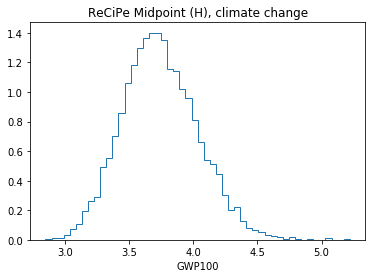

In [80]:
%time res = monte_carlo(m_gly, recipe_methods[0], steps=5000)

In [27]:
from math import floor, ceil, isclose

In [12]:
def find_5_95(_data):
    _l = len(_data)
    _s = sorted(_data)
    _i5 = _s[ceil(_l * 0.05)]
    _i95 = _s[floor(_l * 0.95)]
    return _i5, _i95
    

In [81]:
find_5_95(res) # 5000 iter

(3.2836175445065328, 4.242020444941756)

In [13]:
#  500 iter # find_5_95(res)

(3.2781735320469156, 4.225706533379565)

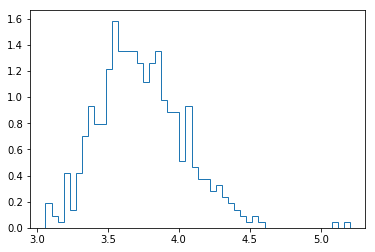

In [37]:
_, bins, _ = plt.hist(res, bins=50, histtype='step', density=1)

In [83]:
xvals = [1.9736567895799773,
 1.9080250484758379,
 7.1549426834270076,
 1.0433618035686494,
 4.5093929469488963,
 0.37972556565244475,
 0.34282567874124636,
 0.25557693565544942,
 2.4545580238122446,
 1.907909564890391,
 5.4086896549761763,
 4.6516863117034823]

yvals = [0.000235253496422294,
 0.120884112034407,
 0.0025873822622544,
 0.109726176278784,
 0.0622621690420671,
 0.0164657626128754,
 0.000240378511370286,
 0.00390097746261021,
 0.00297124710519323,
 0.245909023302167,
 0.310293179807715,
 0.124524338084134]

In [45]:

def _txform_mix(mix, vals, mag, target='mode'):
    """
    transform a mix (summing to 1) and re-normalize
    target='mode': adjust the most-abundant element by mag
    target='highest': adjust the highest-valued element by mag
    target='shift': transfer the lowest-valued mix to the highest-valued. mag not used
    """
    mix = mix.copy()
    assert isclose(sum(mix), 1, rel_tol=1e-8), sum(mix)
    if target=='mode':
        ind = mix.index(max(mix))
        mix[ind] += mag

    elif target=='highest':
        ind = vals.index(max(vals))
        mix[ind] += mag
        
    elif target=='shift':
        _from = vals.index(min(vals))
        _to = vals.index(max(vals))
        mix[_to] += mix[_from]
        mix[_from] = 0
        
    _new = [k / sum(mix) for k in mix]
    assert isclose(sum(_new), 1, rel_tol=1e-8), sum(_new)
    return _new


In [56]:
new_mix

[0.0002138668149293582,
 0.10989464730400639,
 0.09326125660204947,
 0.0997510693443491,
 0.05660197185642464,
 0.014968875102614004,
 0.00021852591942753276,
 0.0035463431478274642,
 0.002701133731993846,
 0.22355365754742457,
 0.28208470891610454,
 0.11320394371284911]

In [65]:
def _add_discrete_bars_to_ax(_ax, _xv, _yv, _norm, _color=[0.7, 0, 0], **kwargs):
    _wid = max(_yv) / _norm
    plt.bar(_xv, [_k / _wid for _k in _yv], width=_wid, color=_color, axes=_ax, **kwargs)

In [64]:
sorted(xvals)

[0.3856077641732449,
 0.5091802348605726,
 0.638275396746632,
 1.057799131779348,
 3.691154477643271,
 3.6918878823664345,
 4.183061622941107,
 4.384712780810435,
 4.67472973221467,
 4.790741214340169,
 5.433935900936027,
 7.169538119825178]

In [86]:
sum(new_mix)

1.0

In [89]:
new_max = 0.5
alpha = (1 - new_max) / (1 - max(yvals))
new_d = [new_max if k == max(yvals) else alpha * k for k in yvals ]

In [91]:
yvals

[0.000235253496422294,
 0.120884112034407,
 0.0025873822622544,
 0.109726176278784,
 0.0622621690420671,
 0.0164657626128754,
 0.000240378511370286,
 0.00390097746261021,
 0.00297124710519323,
 0.245909023302167,
 0.310293179807715,
 0.124524338084134]

In [92]:
new_d

[0.00017054601283825722,
 0.08763441834655589,
 0.001875711669440254,
 0.0795455206954407,
 0.0451366923011642,
 0.011936783957192762,
 0.00017426137043510047,
 0.0028279968737460414,
 0.0021539928402947136,
 0.17827069133056378,
 0.5,
 0.09027338460232825]

In [103]:
nonstart = [m for m in Database('ei3.4 cutoff') if 'market' in m['name'] and not m['name'].startswith('market')]

In [106]:
db = Database('ei3.4 cutoff')

In [108]:
m_t_f_l_u = next(_a for _a in db if _a['activity'] == '8331a025-1307-46b0-a0b8-bdb7398984c2')

In [111]:
m_t_f_l_u.as_dict()

{'comment': '',
 'classifications': [('ISIC rev.4 ecoinvent',
   '4923:Freight transport by road'),
  ('EcoSpold01Categories', 'transport systems/road')],
 'activity type': 'market activity',
 'activity': '8331a025-1307-46b0-a0b8-bdb7398984c2',
 'database': 'ei3.4 cutoff',
 'filename': '8331a025-1307-46b0-a0b8-bdb7398984c2_090f56b8-6a83-48c1-ae26-234d04771e53.spold',
 'location': 'GLO',
 'name': 'market for transport, freight, light commercial vehicle',
 'parameters': [],
 'authors': {'data entry': {'name': '[System]',
   'email': 'support@ecoinvent.org'},
  'data generator': {'name': '[System]', 'email': 'support@ecoinvent.org'}},
 'type': 'process',
 'reference product': 'transport, freight, light commercial vehicle',
 'flow': '090f56b8-6a83-48c1-ae26-234d04771e53',
 'unit': 'ton kilometer',
 'production amount': 1.0,
 'code': 'c22804e9f7dde396d52728cdd3eb10a0'}

In [113]:
nonstart[100].as_dict()

{'comment': 'This dataset changes the names of the (internally used) heat product of waste incineration and connects it with the external grid and the respective average energy markets (district heat grid).',
 'classifications': [('ISIC rev.4 ecoinvent',
   '3821:Treatment and disposal of non-hazardous waste')],
 'activity type': 'ordinary transforming activity',
 'activity': 'c90972e0-8d5c-4066-8ea9-3e47bc24e1fa',
 'database': 'ei3.4 cutoff',
 'filename': 'c90972e0-8d5c-4066-8ea9-3e47bc24e1fa_71e2f1db-a2c5-44d0-8337-dfff15be974d.spold',
 'location': 'TR',
 'name': 'heat, from municipal waste incineration to generic market for heat district or industrial, other than natural gas',
 'parameters': [],
 'authors': {'data entry': {'name': 'Karin Treyer',
   'email': 'karin.treyer@psi.ch'},
  'data generator': {'name': 'Karin Treyer', 'email': 'karin.treyer@psi.ch'}},
 'type': 'process',
 'reference product': 'heat, district or industrial, other than natural gas',
 'flow': '71e2f1db-a2c5-44d

Text(0,0.5,'Relative Frequency')

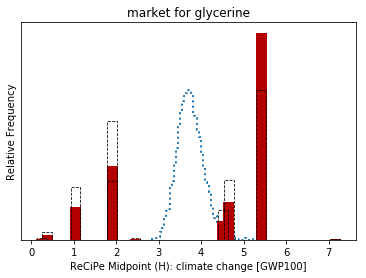

In [96]:
ax = plt.axes()
vv, bins, _ = plt.hist(res, bins=50, axes=ax, histtype='step', density=1, linestyle=':', linewidth=2)
new_mix = _txform_mix(yvals, xvals, 0.1, target='highest')
_add_discrete_bars_to_ax(ax, xvals, new_d, max(vv)/alpha)
_add_discrete_bars_to_ax(ax, xvals, yvals, max(vv), _color='none', linestyle='--', linewidth=0.8, edgecolor='black')
ax.set_yticks([])
ax.set_title(m_gly['name'])
ax.set_xlabel('%s: %s [%s]' % recipe_methods[0])
ax.set_ylabel('Relative Frequency')

In [67]:
from brightway2 import LCA

In [69]:
lca = LCA({m_gly: 1}, method=recipe_methods[0])

In [72]:
lca.lci()

In [73]:
lca.lcia()

In [74]:
lca.score

3.4370894461708037

In [51]:
yvals

[0.000235253496422294,
 0.120884112034407,
 0.0025873822622544,
 0.109726176278784,
 0.0622621690420671,
 0.0164657626128754,
 0.000240378511370286,
 0.00390097746261021,
 0.00297124710519323,
 0.245909023302167,
 0.310293179807715,
 0.124524338084134]

In [50]:
xvals

[4.183061622941107,
 3.6918878823664345,
 7.169538119825178,
 1.057799131779348,
 4.67472973221467,
 0.3856077641732449,
 0.5091802348605726,
 0.638275396746632,
 4.384712780810435,
 3.691154477643271,
 5.433935900936027,
 4.790741214340169]

In [76]:
xvals_nobco2 = [1.9736567895799773,
 1.9080250484758379,
 7.1549426834270076,
 1.0433618035686494,
 4.5093929469488963,
 0.37972556565244475,
 0.34282567874124636,
 0.25557693565544942,
 2.4545580238122446,
 1.907909564890391,
 5.4086896549761763,
 4.6516863117034823]

In [77]:
[ i/j for i,j in zip(xvals, xvals_nobco2)]

[2.1194473350309924,
 1.9349263183497387,
 1.0020399096182808,
 1.0138373171811716,
 1.0366649762420113,
 1.0154906570767583,
 1.4852453198083952,
 2.497390443741408,
 1.7863553186656438,
 1.9346590349817379,
 1.0046677194607798,
 1.029893439350549]

In [78]:
sum(i * j for i, j in zip(xvals_nobco2, yvals))

3.386200307756137

In [79]:
sum(i * j for i, j in zip(xvals_nobco2, new_mix))

3.728813250998944

In [75]:
m_gly.as_dict()

{'comment': '',
 'classifications': [('ISIC rev.4 ecoinvent',
   '2011:Manufacture of basic chemicals'),
  ('EcoSpold01Categories', 'chemicals/organics')],
 'activity type': 'market activity',
 'activity': '037fa5e4-f711-4987-b50a-38920ca5d5a0',
 'database': 'ei3.4 cutoff',
 'filename': '037fa5e4-f711-4987-b50a-38920ca5d5a0_3d3268fa-3c9e-43e0-be88-3dfd53718719.spold',
 'location': 'GLO',
 'name': 'market for glycerine',
 'parameters': [],
 'authors': {'data entry': {'name': '[System]',
   'email': 'support@ecoinvent.org'},
  'data generator': {'name': '[System]', 'email': 'support@ecoinvent.org'}},
 'type': 'process',
 'reference product': 'glycerine',
 'flow': '3d3268fa-3c9e-43e0-be88-3dfd53718719',
 'unit': 'kilogram',
 'production amount': 1.0,
 'code': 'b59e3385667066b01fb72aed604b2b32'}

In [59]:
max(vv)

1.5844580631973344

In [60]:
max(yvals)

0.310293179807715

In [44]:
bins

array([3.05914345, 3.10206033, 3.14497721, 3.18789409, 3.23081098,
       3.27372786, 3.31664474, 3.35956162, 3.40247851, 3.44539539,
       3.48831227, 3.53122915, 3.57414603, 3.61706292, 3.6599798 ,
       3.70289668, 3.74581356, 3.78873045, 3.83164733, 3.87456421,
       3.91748109, 3.96039797, 4.00331486, 4.04623174, 4.08914862,
       4.1320655 , 4.17498238, 4.21789927, 4.26081615, 4.30373303,
       4.34664991, 4.3895668 , 4.43248368, 4.47540056, 4.51831744,
       4.56123432, 4.60415121, 4.64706809, 4.68998497, 4.73290185,
       4.77581873, 4.81873562, 4.8616525 , 4.90456938, 4.94748626,
       4.99040315, 5.03332003, 5.07623691, 5.11915379, 5.16207067,
       5.20498756])

In [40]:
[bins[i] - bins[i-1] for i in range(1, len(bins))]

[0.04291688216902445,
 0.04291688216902401,
 0.04291688216902445,
 0.04291688216902445,
 0.04291688216902445,
 0.04291688216902401,
 0.04291688216902445,
 0.04291688216902445,
 0.04291688216902401,
 0.04291688216902445,
 0.04291688216902445,
 0.04291688216902401,
 0.04291688216902445,
 0.04291688216902445,
 0.04291688216902445,
 0.04291688216902445,
 0.04291688216902401,
 0.04291688216902445,
 0.04291688216902445,
 0.04291688216902401,
 0.04291688216902445,
 0.04291688216902445,
 0.04291688216902401,
 0.04291688216902401,
 0.042916882169024895,
 0.04291688216902401,
 0.042916882169024895,
 0.04291688216902401,
 0.04291688216902401,
 0.042916882169024895,
 0.04291688216902401,
 0.042916882169024895,
 0.04291688216902401,
 0.04291688216902401,
 0.04291688216902401,
 0.042916882169024895,
 0.04291688216902401,
 0.042916882169024895,
 0.04291688216902401,
 0.04291688216902401,
 0.042916882169024895,
 0.04291688216902401,
 0.042916882169024895,
 0.04291688216902401,
 0.04291688216902401,
 0

In [32]:
help(plt.hist)

Help on function hist in module matplotlib.pyplot:

hist(x, bins=None, range=None, density=None, weights=None, cumulative=False, bottom=None, histtype='bar', align='mid', orientation='vertical', rwidth=None, log=False, color=None, label=None, stacked=False, normed=None, hold=None, data=None, **kwargs)
    Plot a histogram.
    
    Compute and draw the histogram of *x*. The return value is a
    tuple (*n*, *bins*, *patches*) or ([*n0*, *n1*, ...], *bins*,
    [*patches0*, *patches1*,...]) if the input contains multiple
    data.
    
    Multiple data can be provided via *x* as a list of datasets
    of potentially different length ([*x0*, *x1*, ...]), or as
    a 2-D ndarray in which each column is a dataset.  Note that
    the ndarray form is transposed relative to the list form.
    
    Masked arrays are not supported at present.
    
    Parameters
    ----------
    x : (n,) array or sequence of (n,) arrays
        Input values, this takes either a single array or a sequence of


In [12]:
[str(x) for x in act.technosphere()]

["Exchange: 0.975409836065573 kilogram 'rare earth concentrate production, 70% REO, from bastnäsite' (kilogram, CN, None) to 'market for rare earth concentrate, 70% REO, from bastnäsite' (kilogram, GLO, None)>",
 "Exchange: 0.0245901639344266 kilogram 'rare earth concentrate production, 70% REO, from bastnäsite' (kilogram, RoW, None) to 'market for rare earth concentrate, 70% REO, from bastnäsite' (kilogram, GLO, None)>"]

In [15]:
act.key

('ei3.4 cutoff', '1ef152c00c4ea0156d9894062730241d')

In [18]:
ei.get('1ef152c00c4ea0156d9894062730241d') == act

True

In [19]:
ei.get('1ef152c00c4ea0156d9894062730241d') is act

False

In [20]:
from brightway2 import LCA

In [22]:
inv = LCA({act:1})

In [24]:
inv.lci()

In [28]:
ei.search('market for transport')

[]

In [33]:
act.

{'comment': 'This product is generally considered to be used at the production site.  Therefore, the market does not contain any transport.',
 'classifications': [('ISIC rev.4 ecoinvent',
   '0729:Mining of other non-ferrous metal ores'),
  ('EcoSpold01Categories', 'chemicals/inorganics')],
 'activity type': 'market activity',
 'activity': 'af42e9b3-5edc-4caf-90a8-edb252f59121',
 'database': 'ei3.4 cutoff',
 'filename': 'af42e9b3-5edc-4caf-90a8-edb252f59121_d85221ba-1d0f-4545-bf95-a2cbf51402dd.spold',
 'location': 'GLO',
 'name': 'market for rare earth concentrate, 70% REO, from bastnäsite',
 'parameters': [],
 'authors': {'data entry': {'name': 'Guillaume Bourgault',
   'email': 'bourgault@ecoinvent.org'},
  'data generator': {'name': '[System]', 'email': 'support@ecoinvent.org'}},
 'type': 'process',
 'reference product': 'rare earth concentrate, 70% REO, from bastnäsite',
 'flow': 'd85221ba-1d0f-4545-bf95-a2cbf51402dd',
 'unit': 'kilogram',
 'production amount': 1.0,
 'code': '1ef15

In [34]:
%time mtflu = next(_a for _a in ei if _a['name'] == 'market for transport, freight, lorry, unspecified')

CPU times: user 450 ms, sys: 517 ms, total: 967 ms
Wall time: 3.32 s


In [1]:
mtflu.as_dict()

NameError: name 'mtflu' is not defined